In [10]:
#Import Libraries
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import math

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Using TensorFlow backend.
C:\Users\MarkB\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\MarkB\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\MarkB\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\MarkB\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

C:\Users\MarkB\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
import os
from datetime import datetime
import pandas_datareader.data as web

#Alpha Vantage API Key "UJ71XR20WEDKVC6M"

In [4]:

#Alpha Advantage API Key
os.environ["ALPHAVANTAGE_API_KEY"] = "UJ71XR20WEDKVC6M"

#start data of retrieval
start_date=datetime(1998, 7, 31)
#end data of retrieval
end_date=datetime(2020, 2, 11)

f = web.DataReader("STN", "av-daily", start_date,
                  end_date,
                  api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [5]:
f.loc["2017-02-10":'2017-02-14']
f.head(3)

,open,high,low,close,volume
2005-08-05,29.10,30.30,29.10,30.20,14800
2005-08-08,30.45,30.65,30.20,30.65,2700
2005-08-09,30.65,30.75,30.25,30.25,4700


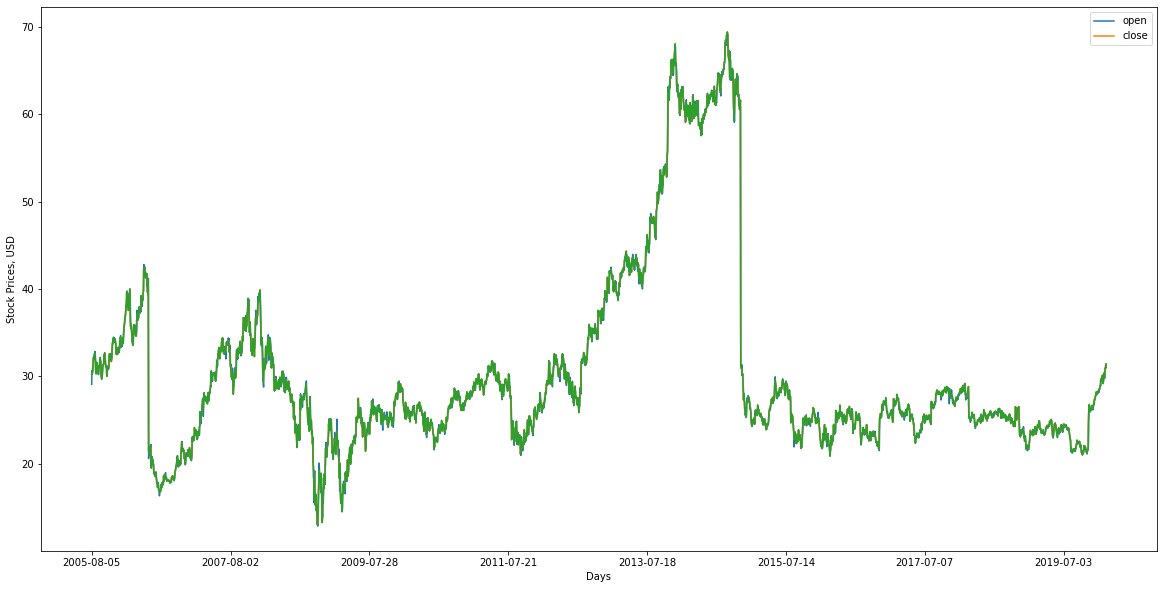

In [6]:
f.plot(y=['open','close'], figsize = (20, 10))
plt.plot(f['close'])
plt.xlabel('Days')
plt.ylabel('Stock Prices, USD')
plt.show()

In [19]:
data = f.filter(['close'])

#Converting the dataframe to a numpy array
dataset = data.values

#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [20]:
data

,close
2005-08-05,30.20
2005-08-08,30.65
2005-08-09,30.25
2005-08-10,30.70
2005-08-11,31.00
...,...
2020-02-05,30.87
2020-02-06,31.09
2020-02-07,31.10
2020-02-10,31.30


In [21]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [22]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]

In [23]:
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [24]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [25]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [26]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [28]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [29]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)


Epoch 1/1
2864/2864 [==============================] - 161s 56ms/step - loss: 0.0022


In [30]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [31]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [32]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

0.8206797222654157

C:\Users\MarkB\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


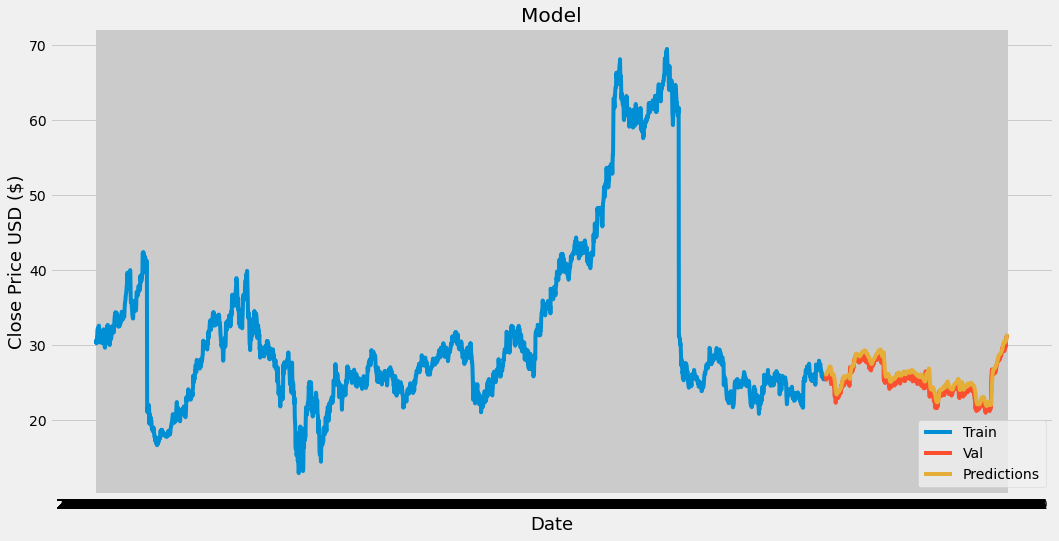

In [34]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

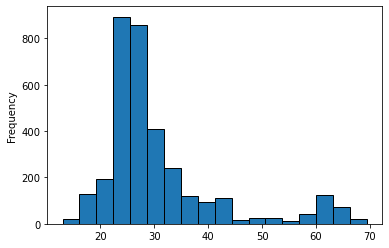

In [7]:
selection = f.loc["2005-08-10":'2019-02-14']
selection['close'].plot.hist(stacked=True, bins=18,edgecolor='black')

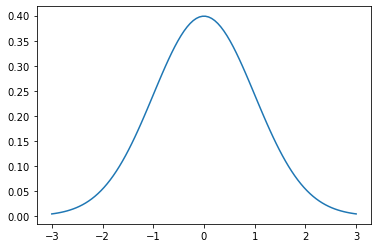

In [8]:
mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [47]:
# Parameter Definitions

# So    :   initial stock price
# dt    :   time increment -> a day in our case
# T     :   length of the prediction time horizon(how many time points to predict, same unit with dt(days))
# N     :   number of time points in the prediction time horizon -> T/dt
# t     :   array for time points in the prediction time horizon [1, 2, 3, .. , N]
# mu    :   mean of historical daily returns
# sigma :   standard deviation of historical daily returns
# b     :   array for brownian increments
# W     :   array for brownian path

## Record Start Value

In [166]:
f.shape[0] - 1
f['close'].iloc[f.shape[0] - 1]

31.42

In [163]:
So = f['close'].iloc[f.shape[0] - 1]
print(So)

31.42


In [156]:
dt = 1
print(dt)

1


In [157]:

end_date
start

datetime.datetime(2017, 2, 10, 0, 0)

In [141]:
pred_end_date = '2020-09-30'

n_of_wkdays = pd.date_range(start = pd.to_datetime(end_date, 
              format = "%Y-%m-%d") + pd.Timedelta('1 days'), 
              end = pd.to_datetime(pred_end_date, 
              format = "%Y-%m-%d")).to_series(
              ).map(lambda x: 
              1 if x.isoweekday() in range(1,6) else 0).sum()
T = n_of_wkdays
print(T)

166


In [142]:
N = T / dt
print(N)

166.0


In [143]:
t = np.arange(1, int(N) + 1)
print(t)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166]


In [169]:
returns = (f['close'].loc[:] - \
           f['close'].shift(1).loc[:])/ \
           f['close'].shift(1).loc[:]
#print(returns.tolist())

In [170]:
mu = np.mean(returns)
print(mu)

0.0003266527544369458


In [171]:
sigma = np.std(returns)
print(sigma)

0.023800716615248567


In [149]:
scen_size = 2
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
print(b)

{'1': array([-7.10711210e-01, -9.05581588e-01,  2.39515234e+00, -1.73262764e-01,
        9.63364820e-01,  6.01673798e-01, -1.29117314e+00,  2.11596547e+00,
        1.11970143e+00,  6.39249705e-03, -5.62575760e-01, -3.51647828e-01,
        3.09768408e-01, -1.58998966e+00,  7.76926493e-01, -4.82104261e-01,
       -2.47504077e-01,  1.46798960e-01,  1.77551339e+00, -9.84001389e-01,
       -7.81503167e-01,  9.87728824e-03,  8.64706153e-01,  8.03629891e-01,
        2.14705528e+00, -5.71736805e-01, -1.07346104e-04, -2.82698754e-01,
        5.16090078e-01,  2.04891097e+00, -7.51154463e-01, -3.81427907e-01,
        3.93227865e-02, -7.92826862e-01,  2.12079576e+00,  4.50619081e-01,
        1.11021866e+00,  2.44419163e-01,  1.97910213e-01,  1.81166875e-01,
       -4.91779198e-01, -1.55393413e+00, -5.91982496e-01, -8.05220972e-01,
        2.46667530e-01, -2.94473067e-01, -4.69626711e-01, -9.07036830e-01,
       -1.62071846e+00,  1.22753742e+00,  1.28820333e+00, -1.81472153e-02,
       -2.59563621e